In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### iJO1366 raw data

In [140]:
class ReactionNode:
    def __init__(self):
        self.id = ""
        self.reagents = []
        self.products = []
    
    def __init__(self, react_id, reagents, products):
        self.id = react_id
        self.reagents = reagents
        self.products = products

In [161]:
class Arc:
    def __init__(self):
        self.start = None
        self.end = None
        
    def __init__(self, startNode, endNode):
        self.start = startNode
        self.end = endNode
    
    def start(self, startNode):
        self.start = startNode
    
    def end(self, endNode):
        self.end = endNode

In [125]:
#species
def get_species(root):
    species = []
    for child in root[0][4]:
        species.append(child.attrib['id'])
    return species

In [138]:
#reactions
def get_reactions(root):
    reactions = []
    for child in root[0][6]:
        reac_id = child.attrib['id']
        reactants, products = None, None
        try:
            reactants = []
            for reactant in child[1]:
                reactants.append(reactant.attrib['species'])
            products = []
            for product in child[2]:
                #print(product.attrib['species'])
                products.append(product.attrib['species'])
        except:
            pass
        newReaction = ReactionNode(reac_id, reactants, products)
        #print(newReaction.id)
        reactions.append(newReaction)
    return reactions


In [179]:
"""
A reaction graph is G = (V, A) where V is a set of reaction nodes, and A is a set of V’s arcs.
There exists an arc from the reaction B to the reaction C when a product of B is consumed by C

This is an inefficient (O(n^2)) way to do this so it takes a while , just as a heads up. There's probably
a better way but for now this is fine
"""
def build_arcs(reactions):
    arcs = []
    for reaction1 in reactions:
        for reaction2 in reactions:
            if reaction1 == reaction2: #no self-edges, is this right?
                break
            consumed = [product in reaction2.reagents for product in reaction1.products]
            if True in consumed:
                newArc = Arc(reaction2, reaction2)
                arcs.append(newArc)
    return arcs
            
    

In [163]:
def count_freqs(length_array):
    freqs = {}
    keys = range(min(length_array), max(length_array)+1)
    for key in keys:
        freqs[key] = 0
    for x in length_array:
        freqs[x] += 1
    return freqs

Num chemical species:  1805
Num reactions:  2583
Mean reactants: 1.959
SD reactants: 2.483
Mean products: 1.983
SD products: 1.160


'\n2 outliers for reactant number:\n"E. coli biomass objective function (iJO1366) - WT - with 53.95 GAM estimate" - 102 reagants\n"E. coli biomass objective function (iJO1366) - core - with 53.95 GAM estimate"- 68 reagants\n'

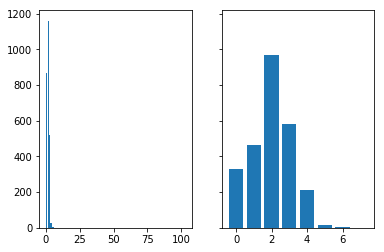

In [192]:
tree = ET.parse('iJO1366.xml')
root = tree.getroot()

species = get_species(root)
reactions = get_reactions(root)

print("Num chemical species: ", len(species))
print("Num reactions: ", len(reactions))

#graphs of counts

num_reactants = [len(x.reagents) for x in reactions]
num_products = [len(x.products) for x in reactions]
reactant_counts = count_freqs(num_reactants)
product_counts = count_freqs(num_products)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.bar(reactant_counts.keys(), reactant_counts.values())
ax2.bar(product_counts.keys(), product_counts.values())

np_reactants = np.array(num_reactants)
np_products = np.array(num_products)
        
print("Mean reactants: {0:.3f}".format(np.average(np_reactants)))
print("SD reactants: {0:.3f}".format(np.std(np_reactants)))
print("Mean products: {0:.3f}".format(np.average(np_products)))
print("SD products: {0:.3f}".format(np.std(np_products)))
        
"""
2 outliers for reactant number:
"E. coli biomass objective function (iJO1366) - WT - with 53.95 GAM estimate" - 102 reagants
"E. coli biomass objective function (iJO1366) - core - with 53.95 GAM estimate"- 68 reagants
"""


In [180]:
#need to prune this eventually - they talk about this a bit in the methods section
"""
Currency metabolites such as ATP, NAD, and H2O are ubiquitously associated with 
metabolic reactions. However, they are not incorporated into the final products. 
As pathways routing through the currency metabolites result in a biologically 
meaningless short path length, the currency metabolites were removed [24, 38, 46]. 
Similarly, transport and exchange reactions occurring at the cell boundary were 
removed, as they do not affect any relationship or reaction flow among 
intracellular reactions, while they inflate the size of the network and the 
average path length, and weaken the modular structure of intracellular connectivity.
"""
arcs = build_arcs(reactions)
print(len(arcs))

175397


### Reactions from adjacency matrix

In [39]:
#automatically reads 1st sheet, which is E. coli
adjacency_matrix = pd.read_excel('12859_2019_2897_MOESM2_ESM.xlsx', index_col=0)

In [11]:
adjacency_matrix.head()

,2AGPEAT120,APH120,FA120ACPHi,FACOAE120,LPLIPAL2A120,LPLIPAL2E120,LPLIPAL2G120,2AGPGAT120,AACPS7,ACPPAT120,...,POAACR,3KGK,ASCBPL,LYXI,GOFUCR,2DGULRx,2DGULRy,3AMACHYD,DOGULNR,MSAR
2AGPEAT120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
APH120,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
FA120ACPHi,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
FACOAE120,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
LPLIPAL2A120,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
adjacency_matrix.tail()

,2AGPEAT120,APH120,FA120ACPHi,FACOAE120,LPLIPAL2A120,LPLIPAL2E120,LPLIPAL2G120,2AGPGAT120,AACPS7,ACPPAT120,...,POAACR,3KGK,ASCBPL,LYXI,GOFUCR,2DGULRx,2DGULRy,3AMACHYD,DOGULNR,MSAR
2DGULRx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2DGULRy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3AMACHYD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
DOGULNR,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
MSAR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
#sanity check, all reactions are identical on both axes
all(adjacency_matrix.columns == adjacency_matrix.index)

True

In [19]:
#also disgustingly O(n^2), sorry
def build_network(adjacency_matrix):
    edges = []
    for row in adjacency_matrix.index:
        for col in adjacency_matrix.columns:
            if adjacency_matrix.at[row, col]:
                new_edge = (row, col)
                edges.append(new_edge)
    return edges

In [20]:
#should be 9099 from paper
am_arcs = build_network(adjacency_matrix)
print(len(am_arcs))

9099


In [37]:
#calculate degree of reaction from how many edges each rxn appears in
am_reactions = adjacency_matrix.index
degrees = {}
for am_reaction in am_reactions:
    edge_contains_react = [am_reaction in edge for edge in am_arcs]
    degrees[am_reaction] = sum(edge_contains_react)
    
sorted_reactions = sorted(degrees.keys(), key = lambda r: degrees[r], reverse=True)
print("Max contact #: {0} {1}".format(sorted_reactions[0], contact_order[sorted_reactions[0]]))
print("Min contact #: {0} {1}".format(sorted_reactions[-1], contact_order[sorted_reactions[-1]]))

np_contact_order = np.array(list(contact_order.values()))
print("Mean contact order: {0:.3f}".format(np.average(np_contact_order)))
print("SD contact order: {0:.3f}".format(np.std(np_contact_order)))
print("Contact order IQR: {0:.3f}".format(np.quantile(np_contact_order, 0.75)-np.quantile(np_contact_order, 0.25)))

Max contact #:  ACOATA  159
Min contact #:  MSAR  1
Mean contact order: 14.547
SD contact order: 19.960
Contact order IQR: 14.000


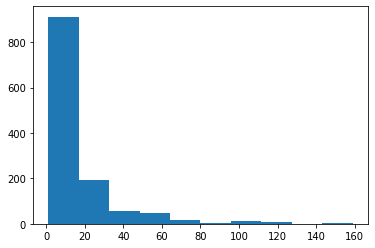

In [25]:
#contact order for each node
plt.hist(contact_order.values())
plt.show()